<a href="https://colab.research.google.com/github/rickconci/COVID_NLP/blob/master/NLP_Covid_conceptproof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP COVID CHALLENGE SUMMARY
## BY Riccardo Conci, Sijin Saji, Keith Tsui

### 5th April 2020

We would like to produce software that is linked to real time publication datasets and produces summary pages for each central research question. Each summary page is comprised of a summaries and conclusions of the key papers, weighted by their evidence, in such a way as to clearly and easily balance research results. 

As an example, we chose a subset of papers from a search of **"chloroquine AND hydroxychloroquine" on LitCovid** (a superior research paper search engine). Out of 25 publications, we identified 7 that were original research. The central question we asked was **"Is hydroxycholoroquine a suitable therapeutic drug for SARS-Cov2"**

Our human annotated dataframe is shown below. 
**Our challenge is to recreate this dataframe in a scalable manner for all COVID related research questions.**

In [0]:
uploaded = files.upload()

Saving Screen Shot 2020-04-05 at 15.13.43.png to Screen Shot 2020-04-05 at 15.13.43.png


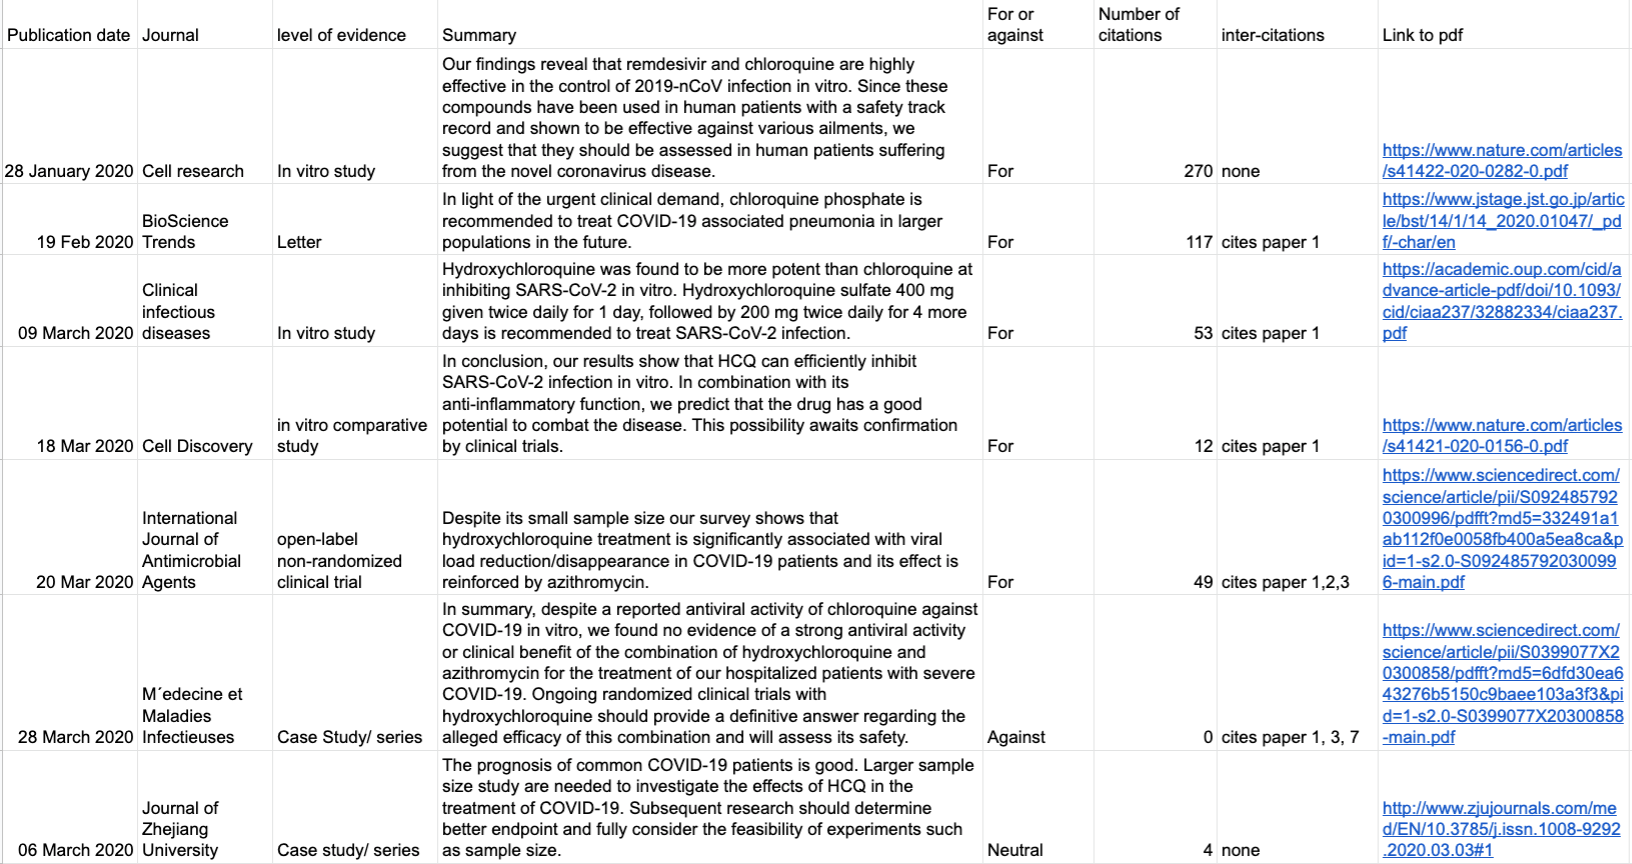

In [0]:
Image("Screen Shot 2020-04-05 at 15.13.43.png", width = 1200)

## Finding papers



The first step to solving this challenge is to get access to a database of research papers related to COVID. 

There are a multitude of databases out there. These include: 

* LitCovid 
* Kaggle CORD dataset 
* WHO recent research 
* OurWorldInData

A brief review of datasets can be found here: https://docs.google.com/spreadsheets/d/1SuB7_q64X3QciOrRkmp277nO9AZT90BSikKDSjg50vI/edit#gid=0






## Finding papers in a scaleable way 

The first challenge is to get hold of research papers and convert them to a string format for further analysis. 

We achived this for our hackathon example by converting PDF research papers into python strings. 



```
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.layout import LAParams
from pdfminer.converter import TextConverter
from pdfminer.pdfpage import PDFPage
import io
import requests


def pdf_to_text(pdf_file):
    text_memory_file = io.StringIO()

    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, text_memory_file, laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # get pages of the pdf file
    for page in PDFPage.get_pages(pdf_file, pagenos=()):
        interpreter.process_page(page)
    text = text_memory_file.getvalue()
    text_memory_file.close()
    return text


# online pdf to text by requests
response = requests.get('https://www.elsevier.com/__data/assets/pdf_file/0007/988648/COVID-19-Drug-Therapy_Mar-2020.pdf')
pdf_memory_file = io.BytesIO()
pdf_memory_file.write(response.content)
text = (pdf_to_text(pdf_memory_file))
```

However, the most scaleable way of taking papers from online is by webscraping. We started coding this for the LitCovid website using the python package **BeautifulSoup**

```
import requests
from bs4 import BeautifulSoup

result = requests.get("https://www.ncbi.nlm.nih.gov/research/coronavirus/docsum")
src = result.content
soup = BeautifulSoup(src, 'lxml')

urls = []
for li_tag in soup.find_all('li'):
    print(li_tag)
    div_tag = li_tag.find('div')
    for div_tag in soup.find_all('a'):
    	urls.append(div_tag.attrs['href'])

print(urls)
```

Relevant resources:

* https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
* https://www.youtube.com/watch?v=87Gx3U0BDlo
* https://github.com/vprusso/youtube_tutorials/blob/master/web_scraping_and_automation/beautiful_soup/white_house_example.py





## Selecting Abstracts & References from each paper 

Once the papers are converted to a coding-friendly form, the next step is to create a **dataframe which includes information of each paper (abstract, intro, methods, etc.), which other papers it has referenced & metadata (date of publication, authors, it's own citations, journal etc)**.  

To do this, the papers need to be cleaned and broken down into their respective parts (Abstract, Methods, Conclusion, Athors etc). 


A sample code that cleans a papers and separates the references from the main body is shown below:

```
def clean_text(text):
    altered_text = re.sub('-\n','', text) #remove line breaks within words
    altered_text = altered_text.lower() #convert to lower 
    altered_text = re.sub('\n', ' ', altered_text) #remove \n

    altered_text = re.sub('-\n','', altered_text) #remove line breaks within words
    main_text = altered_text[:altered_text.rfind("references")] #split between main text and references
    references = altered_text[altered_text.rfind("references"):]
    main_text = re.sub('\[.*?\]', ' ', main_text) #remove references within text 
    main_text = re.sub(r'\s+', ' ', main_text)#remove extra spaces
    
    return [main_text, references]    
```


Relevant links:
* https://stackoverflow.com/questions/48107611/how-to-extract-text-under-specific-headings-from-a-pdf





## Semantic similarity by comparing abstracts 

Once the abstracts of each paper are selected and placed in the main dataframe, we can begin to cluster the papers by topic. This is an NLP based approach inspired by the top Kaggle entry on the CORD COVID competition (https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). 

The figure below shows the result of the algorithm: each paper is a dot on the 2D map, and papers with semantically similar abstracts are clustered together. 

For further information, see https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html



In [0]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving Screen Shot 2020-04-05 at 14.06.37.png to Screen Shot 2020-04-05 at 14.06.37.png


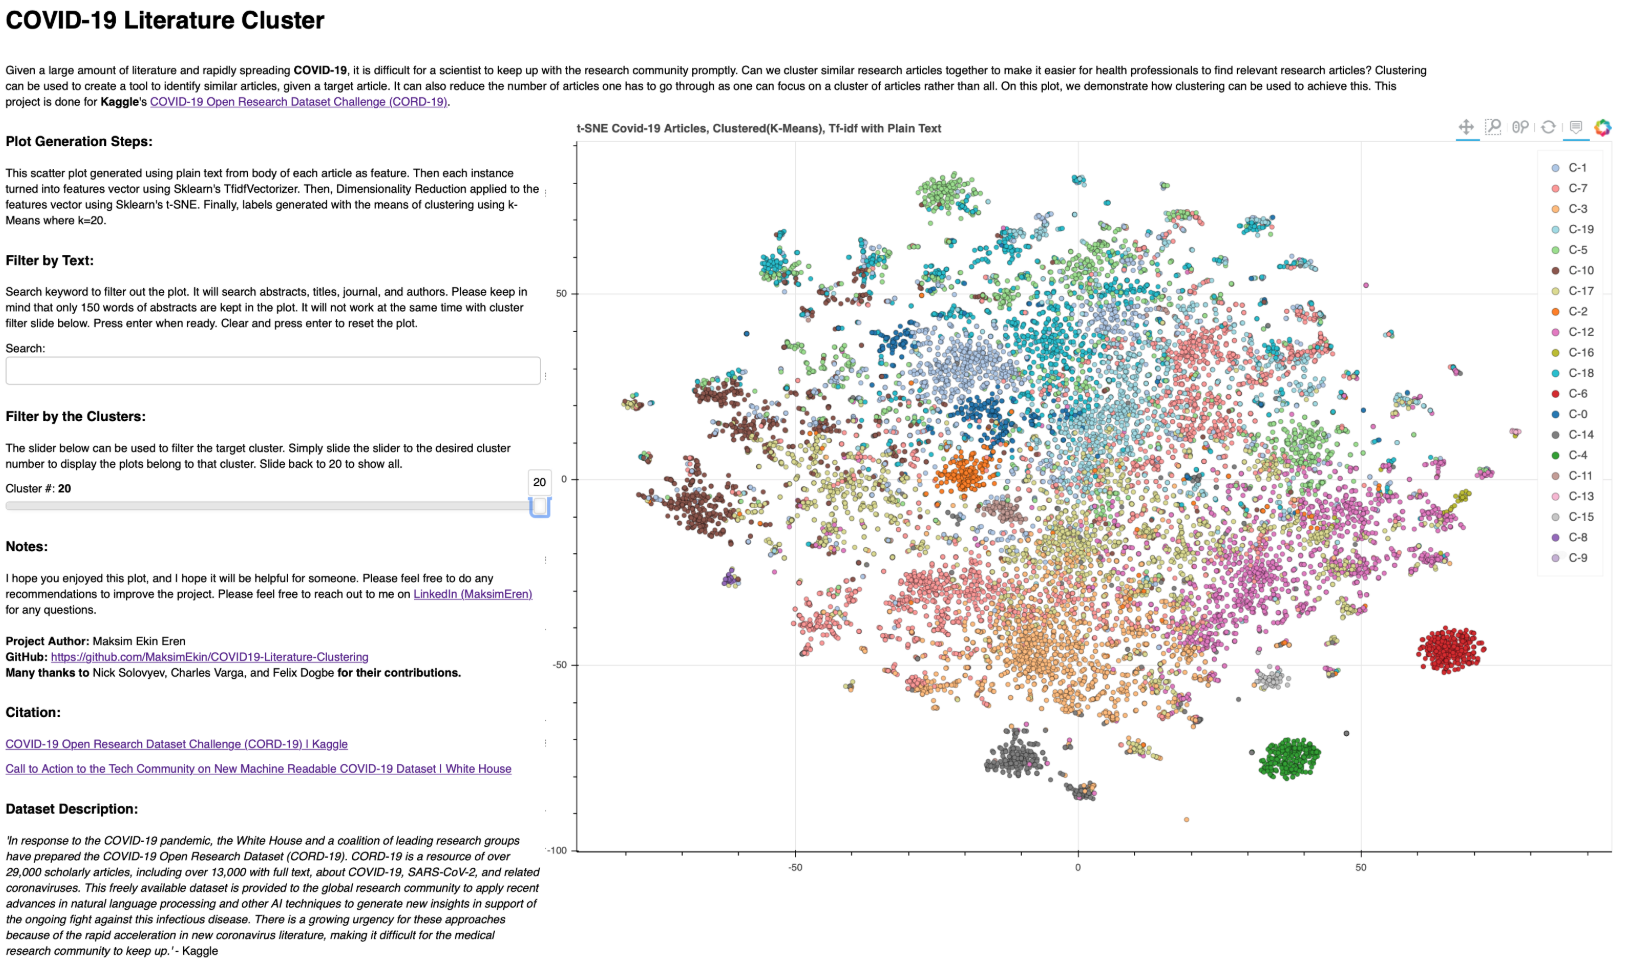

In [0]:
Image('Screen Shot 2020-04-05 at 14.06.37.png', width =1200 )

## Semantic similarity & progress by citation networks


Semantic clustering can occur by comparing the list of references of each paper.

For example,
  paper A has references B, C, E, G, F
  paper B has references D, C, E, L, M
  paper C has references, H, X, K, Z, C

all three have paper C in common and from there they split, such that paper A and B are more similar than paper C.

This clustering can allow us to identify papers that have a common citation network, and therefore are likley to be asking a similar research question. 

One can make even stronger links between papers by selecting references found in the 'background' or 'previous work' section of a paper - these are usually the most relelvant previous research from which the researcher is working. 

**By combining the similarity by abstracts and by citation networks, we can find clusters of papers in an UNSUPERVISED way which gives both a semantic grouping and a sense of progress of the question within that group**


Relevant links:
* https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51


In [0]:
uploaded = files.upload()

Saving Screen Shot 2020-04-05 at 14.26.34.png to Screen Shot 2020-04-05 at 14.26.34.png


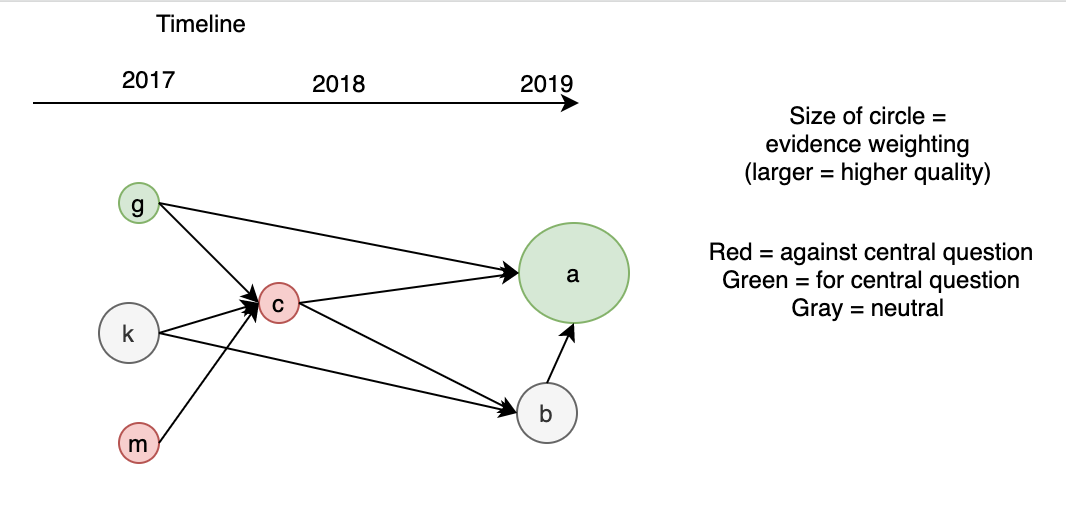

In [0]:
Image("Screen Shot 2020-04-05 at 14.26.34.png", width = 600)

## Providing a central question (label) to each cluster 

Having identified the clusters of papers, we must then identify the **central question** that each cluster is trying to answer. This is a task that requires combining the abstracts/background of the papers in the cluster and **generating free text** in the form of a **question** that best encapsulates the information shown on the papers. 


This can be approached using already built NLP text generators, the most powerful of which is called **GPT-2** from OpenAI 


Relevant links:
* https://openai.com/blog/better-language-models/ & https://towardsdatascience.com/openais-gpt-2-the-model-the-hype-and-the-controversy-1109f4bfd5e8
* https://github.com/assafelovic/nlp_url_summarizer
 


## Selecting relevant summary parts from each paper 

## Providing summary + overall stance to central question 

Having found the central question(s), create an algorithm that takes as input abstract & conclusion for a paper and **outputs**:
  1. **the main conclusion of that paper to the central question(s)**
  2. a set of bullet points that show/summarise the evidence for that conclusion




```
import nltk
nltk.download()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import textblob

stop_words = set(stopwords.words( 'english' ))
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('nor')

conclusion_pro = "Hydroxychloroquine was found to be more potent than chloroquine to inhibit SARS-CoV-2 in vitro."
conclusion_con = "We found no evidence of a strong antiviral activity or clinical benefit of the combination of hydroxychloroquine and azithromycin for the treatment of our hospitalized patients with severe COVID-19"


def clean_up_conclusions(conclusion):
    conc_tokenised = word_tokenize(conclusion)
    filtered_sentence = [w for w in conc_tokenised if not w in stop_words]
    filtered_sentence = []
    for w in conc_tokenised:
        if w not in stop_words:
            filtered_sentence.append(w)
    filtered_sentence_str = ' '.join(filtered_sentence)
    return (filtered_sentence_str)

def getPolarity(text):
    o = textblob.TextBlob(text)
    return (o.sentiment[0])


conc_pro_clean = clean_up_conclusions(conclusion_pro)
conc_con_clean = clean_up_conclusions(conclusion_con)

print('polarity of conclusion pro:' + getPolarity(conc_pro_clean))
print('polarity of conclusion con:' + getPolarity(conc_con_clean))

```



Create algorithm that **gives an evidence weighting to each paper**. comprised of:
  * quality of study (metaanalysis vs cohort unruandomised etc)
  * number of citations of paper in question (also altmetric is good)
  * methodology i.e. sample size, randomised, double blind, ... if modelling - assumptions?
  * combined Q score of researchers/institutions 
  * any other metrics that would normally be used to assess quality



**Collocate the conclusions of different papers** (ranked by evidence weighting & potentially by timeline) into a table/see-saw that balances the papers that agree with the key question vs those that disagree
  * this is mostly a **visualisation exercise** - what is the best way to encapsulate all of the summary points that will allow a clinician/researcher/... to get a quick overall sense of what the research is saying? but also with the possibility of going in more depth easily if they want to?



THE END!!

# NLP primer links


General intro on topic
* https://towardsdatascience.com/automatic-text-summarization-simplified-3b7c10c4093a
* https://en.wikipedia.org/wiki/Automatic_summarization
* https://arxiv.org/pdf/1707.02268.pdf
* https://machinelearningmastery.com/applications-of-deep-learning-for-natural-language-processing/


Coding tips & examples
* https://medium.com/datadriveninvestor/python-data-science-getting-started-tutorial-nltk-2d8842fedfdd
* https://medium.com/jatana/unsupervised-text-summarization-using-sentence-embeddings-adb15ce83db1
* https://stackabuse.com/text-summarization-with-nltk-in-python/
* https://towardsdatascience.com/nlp-for-topic-modeling-summarization-of-legal-documents-8c89393b1534

Video tutorials:
* https://pythonprogramming.net/tokenizing-words-sentences-nltk-tutorial/


In more depth/current research:
* https://www.nature.com/articles/s41586-019-1335-8.pdf
* https://www.quora.com/What-are-the-most-important-research-papers-which-all-NLP-students-should-definitely-read-Why?share=1


General tips for coding:
* https://www.kaggle.com/rtatman/six-steps-to-more-professional-data-science-code

